# XGBoost 3-Class - SMOTE & Recall Optimized

**Goal:** Maximize 'Death' class detection to match Random Forest performance.

**Key Improvements Applied:**
1. **SMOTE Oversampling**: Synthetically increasing 'Death' samples in training data.
2. **Aggressive Class Weights**: Manually setting higher penalties (3.0x) for missing fatal accidents.
3. **Threshold Tuning**: Lowering the probability bar for predicting 'Death'.

In [1]:
pip install xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_fscore_support, roc_auc_score)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## 1. Data Prep & Encoding

In [3]:
df = pd.read_csv('combined_accidents_balanced.csv')

# Select Features
df_sel = df[['injury_severity', 'affected_party', 'primary_accident_type_code', 
             'rain_today', 'vehicle_type_score', 'age_min_encoded', 'rush_hour']].copy()

# Encoding
df_sel['injury_severity'] = df_sel['injury_severity'].map({'minor': 0, 'serious': 1, 'grievous': 1, 'death': 2})
df_sel['affected_party'] = df_sel['affected_party'].map({'pedestrian': 0, 'cyclist': 1, 'motorcyclist': 2, 'driver': 3})
df_sel['primary_accident_type_code'] = df_sel['primary_accident_type_code'].map({'FXOBJ': 0, 'PED': 1, 'COLL': 2, 'OTH': 3})
df_sel['rain_today'] = df_sel['rain_today'].astype(int)
df_sel['rush_hour'] = df_sel['rush_hour'].astype(int)

print("Class Counts (Original):")
print(df_sel['injury_severity'].value_counts().sort_index())

Class Counts (Original):
injury_severity
0     91
1    102
2     39
Name: count, dtype: int64


## 2. Split Data

In [4]:
X = df_sel.drop('injury_severity', axis=1)
y = df_sel['injury_severity']

# Stratified Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## 3. Apply SMOTE (Synthetic Minority Over-sampling)
We artificially generate new 'Death' samples only in the training set to help the model learn the boundary.

In [5]:
# SMOTE to balance the training classes
# k_neighbors=3 because we only have ~27 death samples
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original Train Shape: {y_train.shape}")
print(f"Resampled Train Shape: {y_train_res.shape}")
print("\nResampled Class Distribution:")
print(y_train_res.value_counts())

Original Train Shape: (162,)
Resampled Train Shape: (213,)

Resampled Class Distribution:
injury_severity
1    71
0    71
2    71
Name: count, dtype: int64


## 4. Aggressive Class Weights
Even with SMOTE, we add extra weight to the Death class to force the model to prioritize it.

In [6]:
# Define manual weights to penalize Death errors more heavily
# 0 (Minor): 1.0
# 1 (Serious): 1.5
# 2 (Death): 3.0  <-- Heavy penalty for missing deaths

# Create weights for the resampled data
sample_weights = np.ones(len(y_train_res))
for idx, val in enumerate(y_train_res):
    if val == 1: sample_weights[idx] = 1.5
    if val == 2: sample_weights[idx] = 3.0

print("Weights configured.")

Weights configured.


## 5. Train XGBoost

In [7]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1, 
    reg_lambda=1,
    random_state=42,
    eval_metric='mlogloss',
    objective='multi:softprob'
)

model.fit(X_train_res, y_train_res, sample_weight=sample_weights)
print("✓ Model Trained")

✓ Model Trained


## 6. Threshold Tuning
Standard prediction uses 0.5 probability (or argmax). We will lower the threshold for 'Death' to catch more cases.

In [8]:
def custom_predict(model, X, death_threshold=0.25):
    # Get probabilities for all classes
    probs = model.predict_proba(X)
    
    final_preds = []
    for p in probs:
        # p[0]=Minor, p[1]=Serious, p[2]=Death
        
        # Aggressive Death Detection:
        # If prob(Death) > threshold, predict Death immediately
        if p[2] >= death_threshold:
            final_preds.append(2)
        else:
            # Otherwise standard argmax between remaining classes
            # (We zero out death prob to ignore it in argmax)
            p_temp = p.copy()
            p_temp[2] = -1
            final_preds.append(np.argmax(p_temp))
            
    return np.array(final_preds)

# Find best threshold on Validation set
best_score = 0
best_th = 0.5

print("Optimizing Threshold...")
for th in np.arange(0.1, 0.6, 0.05):
    preds = custom_predict(model, X_val, death_threshold=th)
    # Focus on Death class F1/Recall
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, preds, average=None)
    death_recall = recall[2]
    death_f1 = f1[2]
    
    # We want to maximize a mix of F1 and Recall for Death
    score = death_f1 
    
    if score > best_score:
        best_score = score
        best_th = th
        
print(f"Best Death Threshold found: {best_th:.2f} (Val Death F1: {best_score:.4f})")

Optimizing Threshold...
Best Death Threshold found: 0.15 (Val Death F1: 0.4615)


## 7. Final Evaluation


FINAL RESULTS (Threshold=0.15)
              precision    recall  f1-score   support

       Minor       1.00      0.64      0.78        14
     Serious       1.00      0.20      0.33        15
       Death       0.26      1.00      0.41         6

    accuracy                           0.51        35
   macro avg       0.75      0.61      0.51        35
weighted avg       0.87      0.51      0.53        35



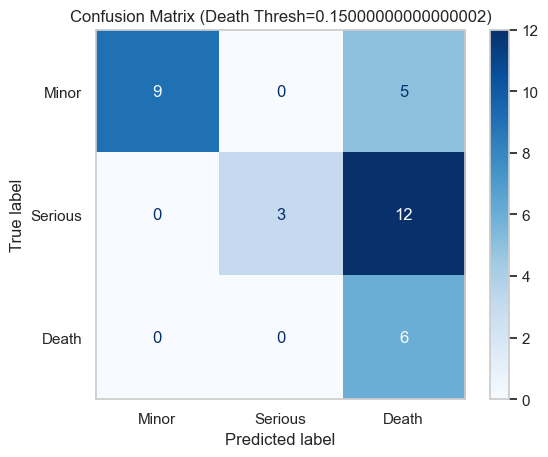

Death Cases Correctly Identified: 6/6 (100.0%)


In [9]:
# Apply optimal threshold to Test Set
y_test_pred = custom_predict(model, X_test, death_threshold=best_th)

print(f"\nFINAL RESULTS (Threshold={best_th:.2f})")
print("="*60)

print(classification_report(y_test, y_test_pred, target_names=['Minor', 'Serious', 'Death']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Minor', 'Serious', 'Death'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.title(f"Confusion Matrix (Death Thresh={best_th})")
plt.show()

death_correct = cm[2,2]
death_total = cm[2].sum()
print(f"Death Cases Correctly Identified: {death_correct}/{death_total} ({death_correct/death_total:.1%})")

## 8. Comprehensive Performance Metrics

In [10]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
f1_macro = f1_score(y_test, y_test_pred, average='macro')
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Calculate ROC-AUC
y_probs = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='weighted')

print("=" * 70)
print("DETAILED PERFORMANCE METRICS")
print("=" * 70)
print(f"\nOverall Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")
print(f"  Macro F1: {f1_macro:.4f}")
print(f"  ROC-AUC (weighted): {roc_auc:.4f}")

print("\nPer-Class Performance:")
print("-" * 30)
class_names = ['Minor', 'Serious', 'Death']
for i, name in enumerate(class_names):
    print(f"{name:<10} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f}")
print("-" * 30)

DETAILED PERFORMANCE METRICS

Overall Performance:
  Accuracy: 0.5143
  Balanced Accuracy: 0.6143
  Weighted F1: 0.5268
  Macro F1: 0.5099
  ROC-AUC (weighted): 0.8160

Per-Class Performance:
------------------------------
Minor      | Precision: 1.0000 | Recall: 0.6429 | F1: 0.7826
Serious    | Precision: 1.0000 | Recall: 0.2000 | F1: 0.3333
Death      | Precision: 0.2609 | Recall: 1.0000 | F1: 0.4138
------------------------------
